In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras 

from tqdm import tqdm
from glob import glob

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'Number of available devices: {len(physical_devices)}')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of available devices: 1


<h3>Data preprocessing</h3>

In [3]:
path_to_train = r'.\Forest fire\Training'
path_to_validation = r'.\Forest fire\Validation'
path_to_test = r'.\Forest fire\Testing'

train_ = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_ = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_dataset = train_.flow_from_directory(path_to_train, 
                                           target_size=(200, 200),
                                           batch_size=2,
                                           class_mode='binary')
validation_dataset = validation_.flow_from_directory(path_to_validation,
                                                     target_size=(200, 200),
                                                     batch_size=2,
                                                     class_mode='binary')

folder_fire = os.path.join(path_to_test, 'fire')
folder_no_fire = os.path.join(path_to_test, 'nofire')

files_fire = glob(folder_fire + '/*.*')
files_no_fire = glob(folder_no_fire + '/*.*')  

dataframe_test = pd.DataFrame()
list_images, list_labels = [], []
for file in tqdm(files_fire):
    image = cv2.imread(file)
    image = cv2.resize(image, (200, 200))
    list_images.append(image)
    list_labels.append(0)
for file in tqdm(files_no_fire):
    image = cv2.imread(file)
    image = cv2.resize(image, (200, 200))
    list_images.append(image)
    list_labels.append(1)
    
dataframe_test['image'] = list_images
dataframe_test['label'] = list_labels

print(train_dataset.class_indices)
print(f'Test dataframe shape: {dataframe_test.shape}')

Found 1706 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


100%|██████████| 46/46 [00:00<00:00, 64.50it/s]


{'fire': 0, 'nofire': 1}
Test dataframe shape: (68, 2)


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
def model():
    input_shape = (200, 200, 3)
    input_layer = Input(shape=(input_shape), name='input_layer')
    
    #block 1 
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = BatchNormalization(name='block1_norm')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block1_pool')(x) 
        
    #block 2
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block2_pool')(x)
    
    #block 3 
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block3_pool')(x)
    x = Dropout(0.4)(x)
    
    #block 4
    x = Flatten()(x)
    x = Dense(units=512, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=256, activation='relu', name='fc2')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=128, activation='relu', name='fc3')(x)
    output_layer = Dense(units=1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizers.SGD(learning_rate=0.001, decay=1e-06, momentum=0.99, nesterov=True),
                     loss=losses.BinaryCrossentropy(),
                         metrics=['accuracy'])
    return model

In [6]:
model = model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_norm (BatchNormalizat (None, 200, 200, 64)      256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)    

In [ ]:
history = model.fit(train_dataset, epochs=10, batch_size=2, validation_data=validation_dataset, verbose=1)

Epoch 1/10
853/853 [==============================] - 338s 397ms/step - loss: nan - accuracy: 0.5158 - val_loss: nan - val_accuracy: 0.5755
Epoch 2/10
853/853 [==============================] - 312s 366ms/step - loss: nan - accuracy: 0.5029 - val_loss: nan - val_accuracy: 0.5755
Epoch 3/10
853/853 [==============================] - 317s 371ms/step - loss: nan - accuracy: 0.5029 - val_loss: nan - val_accuracy: 0.5755
Epoch 4/10
853/853 [==============================] - 329s 386ms/step - loss: nan - accuracy: 0.5029 - val_loss: nan - val_accuracy: 0.5755
Epoch 5/10
  5/853 [..............................] - ETA: 4:44 - loss: nan - accuracy: 0.3000  

In [9]:
tf.keras.models.save_model(model, 'CNN.h5')

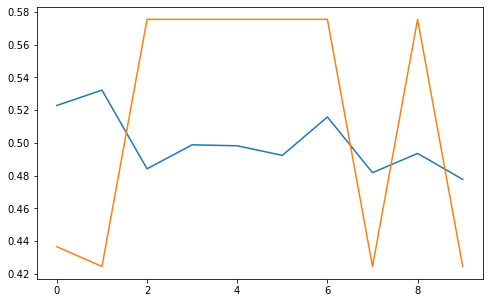

In [11]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])

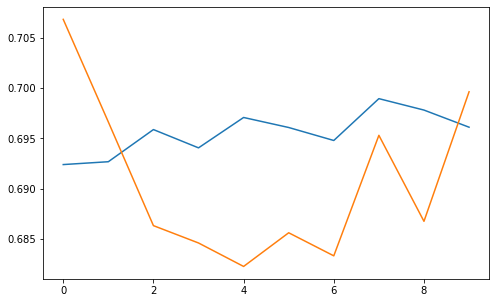

In [12]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])

In [57]:
dataframe_test.head()
X = dataframe_test['image']
X = np.array(X).reshape(-1, 1)
y = dataframe_test['label']

prediction = []
for i in tqdm(range(len(X))):
    x = X[i][0].reshape(-1, 200, 200, 3)
    prediction.append(model.predict(x))

100%|██████████| 68/68 [00:05<00:00, 12.79it/s]


In [58]:
prediction

[array([[0.6985264]], dtype=float32),
 array([[0.53567785]], dtype=float32),
 array([[0.8517731]], dtype=float32),
 array([[0.51952326]], dtype=float32),
 array([[0.881695]], dtype=float32),
 array([[0.88697886]], dtype=float32),
 array([[0.6975991]], dtype=float32),
 array([[0.52281743]], dtype=float32),
 array([[0.5267987]], dtype=float32),
 array([[0.70302206]], dtype=float32),
 array([[0.5282667]], dtype=float32),
 array([[0.6398977]], dtype=float32),
 array([[0.72041434]], dtype=float32),
 array([[0.5230597]], dtype=float32),
 array([[0.8927855]], dtype=float32),
 array([[0.9278912]], dtype=float32),
 array([[0.8158243]], dtype=float32),
 array([[0.5712729]], dtype=float32),
 array([[0.5255407]], dtype=float32),
 array([[0.98100245]], dtype=float32),
 array([[0.7620683]], dtype=float32),
 array([[0.53121716]], dtype=float32),
 array([[0.9301571]], dtype=float32),
 array([[0.8437554]], dtype=float32),
 array([[0.9932921]], dtype=float32),
 array([[0.8394719]], dtype=float32),
 arra

In [46]:
x = X[2][0].reshape(-1, 200, 200, 3)